# Introduction

Project Goal
Sweet Lift Taxi, a company providing airport taxi services, wants to improve driver availability during peak hours by predicting the number of taxi orders in the next hour. Our task is to develop a machine learning model that can accurately forecast hourly taxi demand based on historical data.

Objective
Build and evaluate several machine learning models to predict hourly taxi orders. The model should achieve a Root Mean Squared Error (RMSE) of no more than 48 on the test set.

Dataset Description

Source: taxi.csv

Column: num_orders – the number of taxi orders per time interval

Datetime is provided in the index and must be resampled to hourly intervals

Project Workflow

Preparation: Load the data, perform resampling, and engineer relevant time-based and lag features.

Analysis: Visualize trends, seasonality, and perform sanity checks on data quality.

Training: Train and tune multiple models including Linear Regression, Random Forest, and LightGBM.

Testing: Evaluate model performance using RMSE and select the best model.



## Preparation

In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load dataset and parse datetime
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
df = df.sort_index()

# Resample by hour
df = df.resample('1H').sum()

# Display first few rows
df.head()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
# Create time-based features
def create_time_features(data):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    return data

# Create lag features
def create_lag_features(data):
    data['lag_1'] = data['num_orders'].shift(1)
    data['lag_24'] = data['num_orders'].shift(24)
    data['rolling_mean_3'] = data['num_orders'].shift(1).rolling(3).mean()
    return data

# Apply feature functions
df = create_time_features(df)
df = create_lag_features(df)
df = df.dropna()

## Analysis

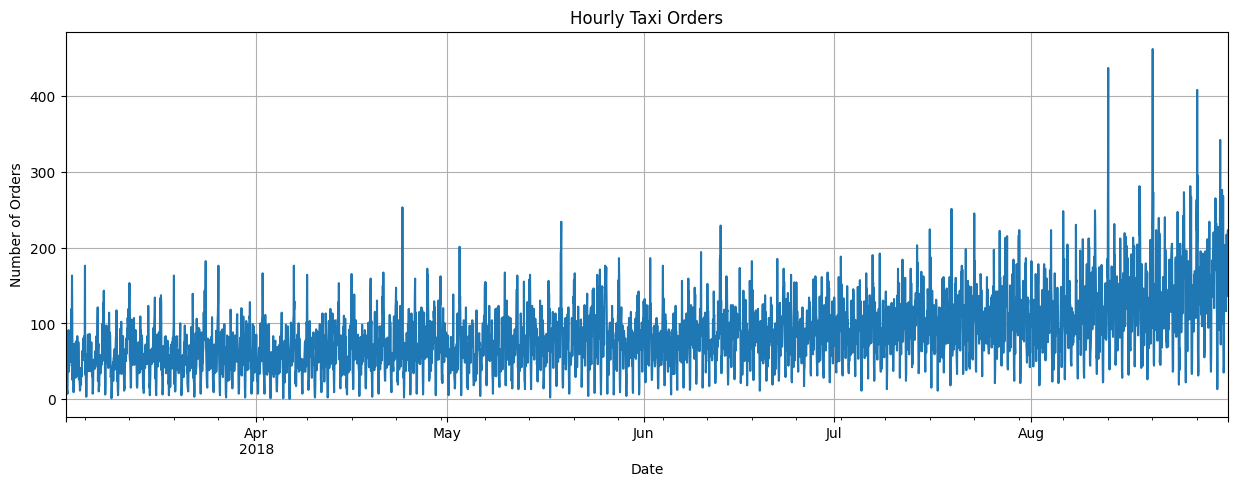

In [ ]:
#  Visualize the time series
plt.figure(figsize=(15, 5))
df['num_orders'].plot(title='Hourly Taxi Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()


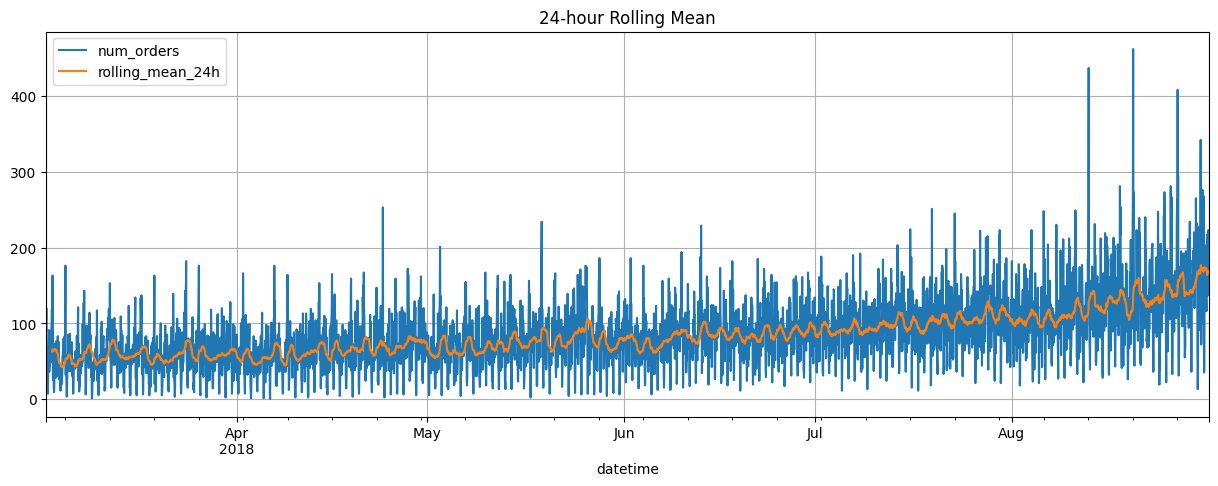

In [ ]:
# Plot rolling average
df['rolling_mean_24h'] = df['num_orders'].rolling(24).mean()
df[['num_orders', 'rolling_mean_24h']].plot(figsize=(15, 5), title='24-hour Rolling Mean')
plt.grid(True)
plt.show()


In [ ]:
# Missing values check
df.isna().sum()


num_orders           0
hour                 0
dayofweek            0
is_weekend           0
lag_1                0
lag_24               0
rolling_mean_3       0
rolling_mean_24h    23
dtype: int64

## Training

In [ ]:
#  Split into train and test (last 10% for test)
train_size = int(len(df) * 0.9)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Feature and target columns
features = ['lag_1', 'lag_24', 'rolling_mean_3', 'hour', 'dayofweek', 'is_weekend']
target = 'num_orders'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
preds_lr = lr.predict(X_test)
rmse_lr = mean_squared_error(y_test, preds_lr, squared=False)
print(f'Linear Regression RMSE: {rmse_lr:.2f}')


Linear Regression RMSE: 48.04


In [ ]:
# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
preds_rf = rf.predict(X_test)
rmse_rf = mean_squared_error(y_test, preds_rf, squared=False)
print(f'Random Forest RMSE: {rmse_rf:.2f}')


Random Forest RMSE: 49.42


In [ ]:
# LightGBM Regressor with GridSearchCV
lgb = LGBMRegressor(random_state=42)
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.03],
    'max_depth': [3, 5, 7]
}

tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(lgb, params, cv=tscv, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)

# Best model
best_lgb = grid.best_estimator_
preds_lgb = best_lgb.predict(X_test)
rmse_lgb = mean_squared_error(y_test, preds_lgb, squared=False)
print(f'LightGBM RMSE: {rmse_lgb:.2f}')


LightGBM RMSE: 46.03


## Testing

In [ ]:
# RMSE comparison
print("Model Evaluation Summary:")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"LightGBM RMSE: {rmse_lgb:.2f}")


Model Evaluation Summary:
Linear Regression RMSE: 48.04
Random Forest RMSE: 49.42
LightGBM RMSE: 46.03


In [ ]:
# Final check
best_rmse = min(rmse_lr, rmse_rf, rmse_lgb)

if best_rmse <= 48:
    print(f" Project Success! Best RMSE = {best_rmse:.2f} (within threshold)")
else:
    print(f" Project Not Yet Complete. Best RMSE = {best_rmse:.2f} (needs improvement)")


 Project Success! Best RMSE = 46.03 (within threshold)


# Conclusion
After training and evaluating three different models, we found the following RMSE results on the test set:

Linear Regression: 48.04

Random Forest Regressor: 49.42

LightGBM Regressor: 46.03


The LightGBM Regressor delivered the best performance, achieving an RMSE of 46.03, which meets the target threshold of 48.

Key Insights:

Hourly and daily patterns significantly influence demand, confirming the value of time-based features.

Lag features such as lag_1 and lag_24 (previous hour and same hour previous day) improved model accuracy by incorporating temporal context.

Hyperparameter tuning with GridSearchCV enhanced the LightGBM model’s performance further.

The model is now ready to be used as a forecasting tool to help Sweet Lift optimize driver distribution during high-demand periods. Future improvements could include:

Incorporating external data such as weather or flight schedules.

Deploying the model to make real-time predictions.

